In [17]:
# # Mount Google Drive
# from google.colab import drive
# import shutil
# import sys

# # Mount drive
# drive.mount('/drive', force_remount=True)
# # Set path
# sys.path.append('/drive/My Drive/COMS6998')

# !cp -r '/drive/My Drive/COMS6998/fundamentals.csv' '/fundamentals.csv'
# !cp -r '/drive/My Drive/COMS6998/prices-split-adjusted.csv' '/prices-split-adjusted.csv.csv'
# !cp -r '/drive/My Drive/COMS6998/prices.csv' '/prices.csv'

Mounted at /drive


In [0]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy import stats
import torch
import matplotlib.pyplot as plt



price = pd.read_csv("/prices-split-adjusted.csv")

fundamental = pd.read_csv("/fundamentals.csv")

fundamental.rename(columns={'Ticker Symbol': 'symbol', 'Period Ending': 'date'}, inplace=True)

fundamental['date']=pd.to_datetime(fundamental['date'])
price['date']=pd.to_datetime(price['date'])

price = price.sort_values([ 'date','symbol']).reset_index()
fundamental = fundamental.sort_values(['date','symbol']).reset_index(drop=True)


#data = pd.merge_asof(price,fundamental,on='date',by='symbol')#,tolerance=pd.Timedelta('90days'))
data = pd.merge(price,fundamental,on=['date','symbol']).reset_index(drop=True)
data['e2p'] = data['Earnings Per Share']/data['close']

data['return'] = (data['close']/data['open']-1)
norm_by_asset_factor = ['Capital Expenditures','Goodwill','Fixed Assets']
data[norm_by_asset_factor] = data[norm_by_asset_factor].div(data['Total Assets'], axis=0)
data['FCF Margin']= data['Net Cash Flow-Operating']/data['Total Revenue']

data.dropna(subset=['return','symbol'],inplace=True)#, 'born'])

data=data.fillna(0)

features = ['e2p', 'Cash Ratio','Gross Margin','Profit Margin','Current Ratio','Operating Margin','Short-Term Debt / Current Portion of Long-Term Debt','FCF Margin']+norm_by_asset_factor

X_train = data[features].values
y_train = data['return'].values


X_train=stats.zscore(X_train, axis=1, ddof=1)
#y_train=stats.zscore(y_train, axis=1, ddof=1)

X_data = torch.tensor(X_train, dtype=torch.float)
y_data = torch.tensor(y_train, dtype=torch.float)





In [0]:
#!pip install http://download.pytorch.org/whl/cpu/torch-0.4.0-cp27-cp27mu-linux_x86_64.whl 
#!pip install pyro-ppl

import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import math

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine


# The true model, with randomly generated weights and fixed noise level
#noise_level = 0.1
x = X_data
y = y_data

In [179]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)
   #     self.factor = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
      #  print (x.shape)
        return self.linear(x) #+ (self.factor * x[:, 0] * x[:, 1]).unsqueeze(1)

regression_model = RegressionModel(11)

# loc = torch.zeros(1, 1)
# scale = torch.ones(1, 1)
# # define a unit normal prior
# prior = Normal(loc, scale)
# # overload the parameters in the regression module with samples from the prior
# lifted_module = pyro.random_module("regression_module", regression_model, prior)
# # sample a nn from the prior
# sampled_reg_model = lifted_module()

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:347: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


In [0]:
pyro.enable_validation(True)
pyro.clear_param_store()

In [0]:
# The prior
def model(x,y):
  # alpha = torch.tensor(0.0)
  # beta = torch.tensor(1.0)
  # w_prior = pyro.sample( "w_prior",Normal(alpha, beta).expand([11]).to_event(1))
  # w_prior = pyro.sample( 'w_prior',Normal(torch.tensor(0.0), torch.tensor(1.0)).expand([11]).to_event(1)) 
  # b_prior = pyro.sample('b_prior',Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])))
  w_prior = Normal(torch.tensor(0.0), torch.tensor(1.0)).expand([1,11]).to_event(1)
  b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)

  priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
  sigma = pyro.sample("sigma", Uniform(0.,10.))

  lifted_module = pyro.random_module("module", regression_model, priors)
  lifted_reg_model = lifted_module()

  #mu = a + w_prior*x
  #for i in pyro.plate("data_loop", len(x)):
  with pyro.plate("map", len(x)):
    prediction_mean = lifted_reg_model(x).squeeze(-1)
    # prediction_mean =  w_prior*x
    pyro.sample("obs", Normal(prediction_mean, sigma), obs=y)


from pyro.infer.autoguide import AutoDiagonalNormal

guide = AutoDiagonalNormal(model)


In [186]:
optimizer = pyro.optim.SGD({"lr": 1e-4, "momentum": 0.1})
pyro.clear_param_store()
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())
rec_loss = []
for i in range(1000):
    loss = svi.step(x,y)
    rec_loss.append(loss)
    print('Iter %d, loss = %g' % (i,loss))

/usr/local/lib/python3.6/dist-packages/pyro/primitives.py:347: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  "modules from `torch.nn.Module` instances.", FutureWarning)


Iter 0, loss = 1011.98
Iter 1, loss = 793.835
Iter 2, loss = 801.596
Iter 3, loss = 558.47
Iter 4, loss = 474.981
Iter 5, loss = 451.899
Iter 6, loss = 498.918
Iter 7, loss = 250.662
Iter 8, loss = 650.204
Iter 9, loss = 1580.88
Iter 10, loss = 2114.13
Iter 11, loss = 1046.2
Iter 12, loss = 761.123
Iter 13, loss = 811.637
Iter 14, loss = 738.776
Iter 15, loss = 1178.69
Iter 16, loss = 790.503
Iter 17, loss = 890.415
Iter 18, loss = 1393.57
Iter 19, loss = 1296.32
Iter 20, loss = 4830.11
Iter 21, loss = 2556.91
Iter 22, loss = 2017.31
Iter 23, loss = 1742.22
Iter 24, loss = 1411.4
Iter 25, loss = 1485.23
Iter 26, loss = 1401.54
Iter 27, loss = 1142.22
Iter 28, loss = 1157.69
Iter 29, loss = 1080.83
Iter 30, loss = 1153.9
Iter 31, loss = 1031.86
Iter 32, loss = 1153.06
Iter 33, loss = 964.478
Iter 34, loss = 854.987
Iter 35, loss = 955.535
Iter 36, loss = 809.853
Iter 37, loss = 705.787
Iter 38, loss = 489.572
Iter 39, loss = 1102.91
Iter 40, loss = 1136.1
Iter 41, loss = 1683.27
Iter 42

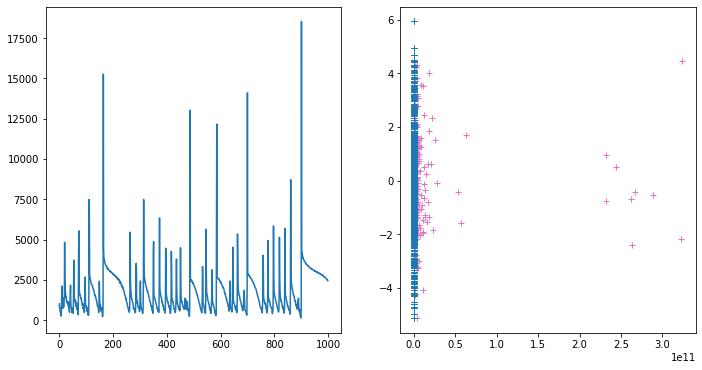

In [187]:
fig = plt.figure(figsize = (18,6))
plt.subplot(131)
plt.plot(rec_loss)

plt.subplot(132)
plt.plot(xs.numpy(),ys.numpy(),'+')


In [0]:


# class RegressionModel(nn.Module):
#     def __init__(self, in_features, out_features):
#         super(RegressionModel, self).__init__()
#         self.linear = nn.Linear( 11,1)
#         self.linear.weight = pyro.sample('w_prior',Normal(0., 1.).expand([11, 1]).to_event(2))
#         self.linear.bias = pyro.sample('b_prior',Normal(0., 10.).expand([1]).to_event(1))

#     def forward(self, x, y=None):
#         sigma = pyro.sample("sigma", Uniform(0., 10.))
#         mean = self.linear(x).squeeze(-1)
#         with pyro.plate("data", x.shape[0]):
#             obs = pyro.sample("obs", Normal(mean, sigma), obs=y)
#         return mean

In [0]:
# # The variational distribution
# def guide(x,y):
#   alphas = pyro.param('alphas', torch.tensor(0.).expand(11))
#   betas = pyro.param('betas', torch.tensor(1.).expand(11)) 

#   pyro.sample( "w_prior",Normal(alphas, betas).expand([11]).independent(1))
#   pyro.sample("sigma", Uniform(alphas,betas).expand([11]).independent(1))

#  #